# 01 Feature extraction

In [1]:
%matplotlib inline

import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Some global variables
img_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/Swissroads_imgs/'
features_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/'
batch_size = 32
npixels = 224

In [3]:
# Create image generator
train_generator = ImageDataGenerator(rescale=1/255)
valid_generator = ImageDataGenerator(rescale=1/255)
test_generator = ImageDataGenerator(rescale=1/255)

In [4]:
# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join(img_basepath, 'train'), batch_size=batch_size, target_size=(npixels, npixels),
    shuffle=True)
validset = valid_generator.flow_from_directory(
    os.path.join(img_basepath, 'valid'), batch_size=batch_size, target_size=(npixels, npixels),
    shuffle=True)
testset = test_generator.flow_from_directory(
    os.path.join(img_basepath, 'test'), batch_size=batch_size, target_size=(npixels, npixels),
    shuffle=False)

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [5]:
print(trainset.index_array)
print(testset.index_array)
trainset.samples

None
None


280

In [6]:
# Create graph
img_graph = tf.Graph()

with img_graph.as_default():
    # Download module
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'
    feature_extractor = hub.Module(module_url)

    # Create input placeholder
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, npixels, npixels, 3])

    # A node with the features
    imgs_features = feature_extractor(input_imgs)

    # Collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(), tf.tables_initializer()
    ])

img_graph.finalize()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)

# Get features
print('train set')
for batch, (batch_imgs, batch_labels) in enumerate(trainset):
    print('    batch:', batch)
    idx = trainset.index_array[batch*trainset.batch_size:(batch+1)*trainset.batch_size]
    if batch == 0:
        features_tr = sess.run(imgs_features, feed_dict={input_imgs: batch_imgs})
        labels_tr = batch_labels        
        fnames_tr = np.array(trainset.filenames)[idx]
    else:
        features_tr = np.append(
            features_tr, sess.run(imgs_features, feed_dict={input_imgs: batch_imgs}), axis=0)
        labels_tr = np.append(labels_tr, batch_labels, axis=0)
        fnames_tr = np.append(fnames_tr, np.array(trainset.filenames)[idx])
    if batch >= trainset.batch_index:
        break
print(features_tr.shape)
np.savez(
    os.path.join(features_basepath, 'Swissroads_train.npz'),
    data=features_tr, labels=labels_tr, names=list(trainset.class_indices.keys()),
    filenames=fnames_tr)

print('valid set')        
for batch, (batch_imgs, batch_labels) in enumerate(validset):    
    print('    batch:', batch)
    idx = validset.index_array[batch*validset.batch_size:(batch+1)*validset.batch_size]
    if batch == 0:
        features_va = sess.run(imgs_features, feed_dict={input_imgs: batch_imgs})
        labels_va = batch_labels
        fnames_va = np.array(validset.filenames)[idx]
    else:
        features_va = np.append(
            features_va, sess.run(imgs_features, feed_dict={input_imgs: batch_imgs}), axis=0)
        labels_va = np.append(labels_va, batch_labels, axis=0)
        fnames_va = np.append(fnames_va, np.array(validset.filenames)[idx])
    if batch >= validset.batch_index:
        break
print(features_va.shape)
np.savez(
    os.path.join(features_basepath, 'Swissroads_valid.npz'),
    data=features_va, labels=labels_va, names=list(validset.class_indices.keys()),
    filenames=fnames_va)
    
print('test set')        
for batch, (batch_imgs, batch_labels) in enumerate(testset):
    print('    batch:', batch)
    idx = testset.index_array[batch*testset.batch_size:(batch+1)*testset.batch_size]
    if batch == 0:
        features_te = sess.run(imgs_features, feed_dict={input_imgs: batch_imgs})
        labels_te = batch_labels
        fnames_te = np.array(testset.filenames)[idx]
    else:
        features_te = np.append(
            features_te, sess.run(imgs_features, feed_dict={input_imgs: batch_imgs}), axis=0)
        labels_te = np.append(labels_te, batch_labels, axis=0)
        fnames_te = np.append(fnames_te, np.array(testset.filenames)[idx])
    if batch >= testset.batch_index:
        break
print(features_te.shape)
np.savez(
    os.path.join(features_basepath, 'Swissroads_test.npz'),
    data=features_te, labels=labels_te, names=list(testset.class_indices.keys()),
    filenames=fnames_te)

train set
    batch: 0
    batch: 1
    batch: 2
    batch: 3
    batch: 4
    batch: 5
    batch: 6
    batch: 7
    batch: 8
(280, 1280)
valid set
    batch: 0
    batch: 1
    batch: 2
    batch: 3
    batch: 4
(139, 1280)
test set
    batch: 0
    batch: 1
(50, 1280)


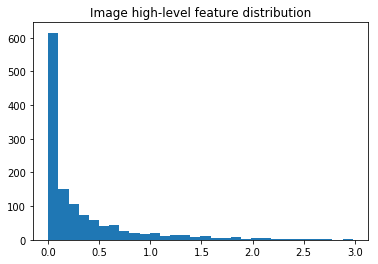

In [8]:
# Plot feature example
plt.hist(features_tr[0], bins=30)
plt.title('Image high-level feature distribution')
plt.show()